In [187]:
%matplotlib inline
import glob
from itertools import izip
import os

from IPython.core.display import HTML, SVG
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib_venn import venn3, venn2
import scipy

from gscripts.clipseq import clipseq_barcode_metrics
from gscripts.general import dataviz
from gscripts.general import parsers
from gscripts.general import region_helpers
from gscripts.GO import hg19GO, mm9GO
from collections import Counter
img_dir = "/nas3/gpratt/Dropbox/Musashi/"

In [4]:
%load_ext autoreload
%autoreload 2
reload(parsers)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'gscripts.general.parsers' from '/nas/nas0/gpratt/gscripts/gscripts/general/parsers.pyc'>

In [ ]:
gene_id_to_name_hg19 = region_helpers.gene_id_to_name("/nas3/gpratt/gencode/gencode.v17.annotation.gtf.db")
gene_id_to_type_hg19 = region_helpers.gene_id_to_type("/nas3/gpratt/gencode/gencode.v17.annotation.gtf.db")

gene_id_to_name_mm9 = region_helpers.gene_id_to_name("/nas3/gpratt/gencode/gencode.vM1.annotation.gtf.db")


In [158]:
def gene_id_mapper_hg19(interval):
    interval.name = gene_id_to_name_hg19[interval.name.split("_")[0]]
    return interval

def gene_id_mapper_mm9(interval):
    interval.name = gene_id_to_name_mm9[interval.name.split("_")[0]]
    return interval

def counts_to_rpkm(featureCountsTable):
    counts = featureCountsTable.ix[:,5:]
    lengths = featureCountsTable['Length']
    mapped_reads = counts.sum()
    return (counts * pow(10,9)).div(mapped_reads, axis=1).div(lengths, axis=0)

def plot_go_enrichment(df, filter_value=None, max_terms=None, **kwargs):
    df = df.copy()
    new_index = []
    for index, description in izip(df.index, df['GO Term Description']):
        new_index.append(list(index[:-1]) + [description])
    df.index = pd.MultiIndex.from_tuples(new_index)

    go_matrix = df['Bonferroni-corrected Hypergeometric p-Value'].apply(lambda x: -1 * np.log10(x))
    go_matrix = go_matrix.unstack(range(len(go_matrix.index.levels) - 1))
    go_matrix = go_matrix.fillna(0)
    
    #Set cutoff on values 
    if filter_value is not None:
        go_matrix = go_matrix[go_matrix.apply(max, axis=1) > filter_value]
    
    #Set cutoff on number of go terms to show
    if max_terms is not None:
        go_matrix = go_matrix.ix[go_matrix.max(axis=1).order(ascending=False).index].ix[:max_terms]
        
    go_matrix[go_matrix == np.inf] = -1
    go_matrix[go_matrix == -1] = go_matrix.values.max()
    
    sns.clustermap(go_matrix, robust=True, **kwargs)

In [222]:
!mkdir -p /nas3/gpratt/projects/msi2/analysis/msi2_v2/
!scp -q tscc-login.sdsc.edu:/home/gpratt/projects/msi2/analysis/msi2_v2/*{metrics,.bed,final.out,svg,pickle} /nas3/gpratt/projects/msi2/analysis/msi2_v2/

In [7]:
iclip_metrics = parsers.clipseq_metrics("/nas3/gpratt/projects/msi2/analysis/msi2_v2/")
filtered_df = iclip_metrics[["Input Reads", "repetitive_count", "Reads Passing Quality Filter", "Uniquely Mapped Reads", "Uniquely mapped reads %", "Usable Reads", 'Num Peaks', u'Percent Usable / Input',
]]                            
HTML(filtered_df.to_html(formatters={"Input Reads" : parsers.commas, "Reads After Triming" : parsers.commas,
                                     "Reads Passing Quality Filter" : parsers.commas, "Uniquely Mapped Reads" : parsers.commas,
                                     "Usable Reads" : parsers.commas, "Num Peaks": parsers.commas, "repetitive_count": parsers.commas,} ))

,Input Reads,repetitive_count,Reads Passing Quality Filter,Uniquely Mapped Reads,Uniquely mapped reads %,Usable Reads,Num Peaks,Percent Usable / Input
MSI2_ACAGTG_ACAGTG_L008_R1,"60,059,965","10,557,356","57,655,483","10,557,356",18.31%,"456,390","25,920",0.043230
MSI2_CAGATC_CAGATC_L008_R1,"59,001,980","19,121,627","52,107,755","19,121,627",36.70%,"95,924","7,698",0.005017
MSI2_GCCAAT_GCCAAT_L008_R1,"152,525","37,987","127,828","37,987",29.72%,"3,929",305,0.103430
MSI2_TAGCTT_TAGCTT_L008_R1,"77,513","18,854","66,893","18,854",28.19%,"22,044",456,1.169195
MSI2_TGACCA_TGACCA_L008_R1,"101,367","21,121","67,667","37,752",55.79%,"2,647",746,0.070115
MSI2_TTAGGC_TTAGGC_L008_R1,"86,861,473","24,076,434","57,970,220","40,305,999",69.53%,"349,403","25,243",0.008669


There is a really high number of repetitive reads, and mapping changed a lot without changing the number of usable reads.  This is really interesting and might suggest to me binding of some sort of repeitive element.  I'll check for it down below

In [8]:
pd.DataFrame({"Fraction 3' RNA Adapter": { "MSI2_ACAGTG_ACAGTG_L008_R1.fastq.gz": 7579942 / 52081382.,

"MSI2_CAGATC_CAGATC_L008_R1.fastq.gz": 27355006 / 53837810.,

"MSI2_GCCAAT_GCCAAT_L008_R1.fastq.gz": 46406 / 123931. ,

"MSI2_TAGCTT_TAGCTT_L008_R1.fastq.gz": 18320 / 60517. ,

"MSI2_TGACCA_TGACCA_L008_R1.fastq.gz": 22787 / 78734. ,

"MSI2_TTAGGC_TTAGGC_L008_R1.fastq.gz": 16155384 / 67159228.,}})



,Fraction 3' RNA Adapter
MSI2_ACAGTG_ACAGTG_L008_R1.fastq.gz,0.145540
MSI2_CAGATC_CAGATC_L008_R1.fastq.gz,0.508100
MSI2_GCCAAT_GCCAAT_L008_R1.fastq.gz,0.374450
MSI2_TAGCTT_TAGCTT_L008_R1.fastq.gz,0.302725
MSI2_TGACCA_TGACCA_L008_R1.fastq.gz,0.289418
MSI2_TTAGGC_TTAGGC_L008_R1.fastq.gz,0.240553


Main Takeaways:
----------------

1. Samples GCCAAT, TAGCTT and TGACCA failed due to a lack of sequencing depth
2. Sample CAGATC failed due to a low percent usable usable reads and a low number of usable reads overall
3. The other two samples are borderline.  If it were my data I wouldn't trust them due to a low number of usable reads, but they might be able to be salvaged if there is enrichment in specific known regions or results are consistant with previously published data

#Raw Data

You can find browser tracks for both human and mouse in this genome browser session:

http://genome.ucsc.edu/cgi-bin/hgTracks?db=hg19&position=chr17%3A55333931-55757299&hgsid=395270045_AmAWamtoStiGOpyxQeb4Twcv07DM

The actual trackhubs are here:


https://s3-us-west-1.amazonaws.com/sauron-yeo/msi2_human/hub.txt

https://s3-us-west-1.amazonaws.com/sauron-yeo/msi2_mouse/hub.txt

#CLIP Analysis Results
The results below are for all clip analysis runs, even if they looked bad.  Keep in mind of the results shown below I only trust CAGATC, and barely.  I've included the rest for due diligance.  (I'll update these results to have the other two QC reports when they are done running, they crashed for unknown reasons, I'm currently investigating) 

ACAGTG Analysis
---------

In [188]:
!cp /nas3/gpratt/projects/msi2/analysis/msi2_v2/MSI2_ACAGTG_ACAGTG_L008_R1.polyATrim.adapterTrim.rmDup.sorted.peaks.bed.qc_fig.svg $img_dir

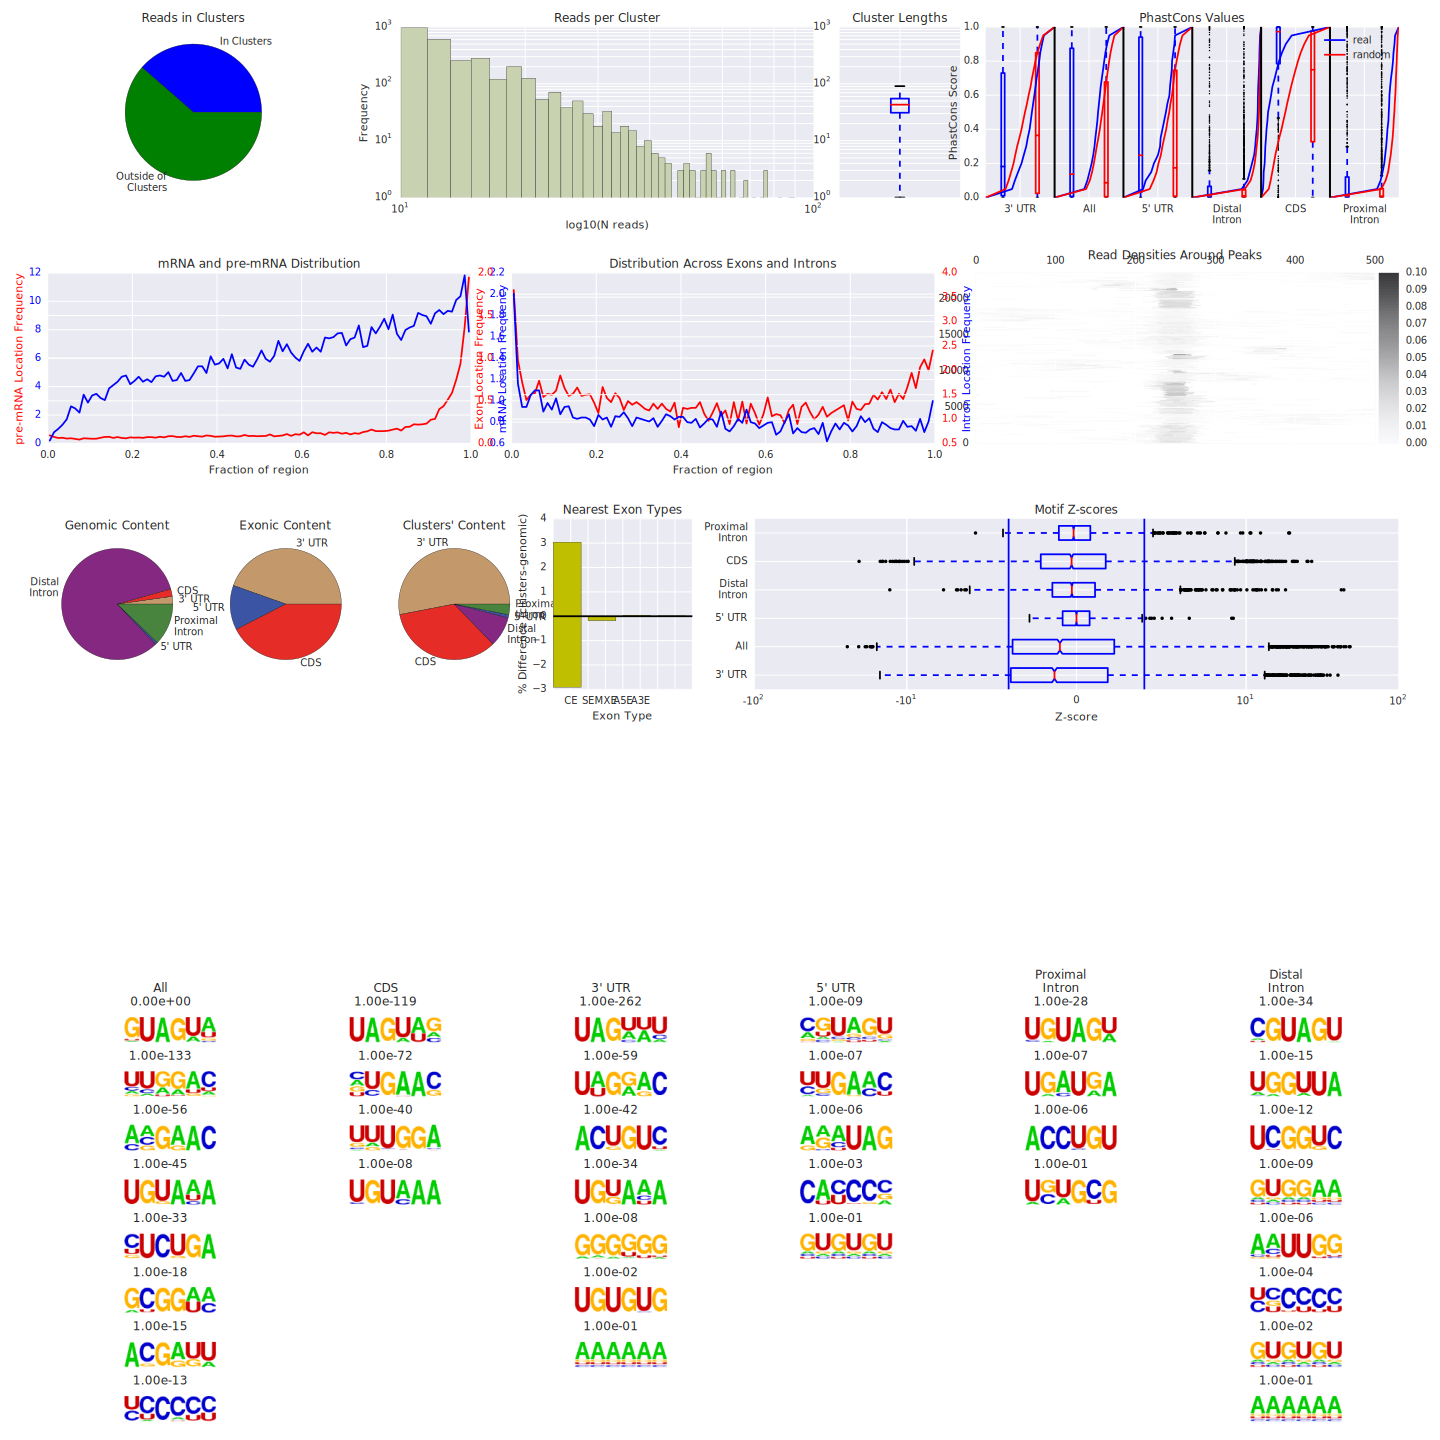

In [9]:
SVG("/nas3/gpratt/projects/msi2/analysis/msi2_v2/MSI2_ACAGTG_ACAGTG_L008_R1.polyATrim.adapterTrim.rmDup.sorted.peaks.bed.qc_fig.svg")

In [189]:
!cp /nas3/gpratt/projects/msi2/analysis/msi2_v2/MSI2_ACAGTG_ACAGTG_L008_R1.polyATrim.adapterTrim.rmDup.sorted.peaks.bed.DistFig.svg $img_dir

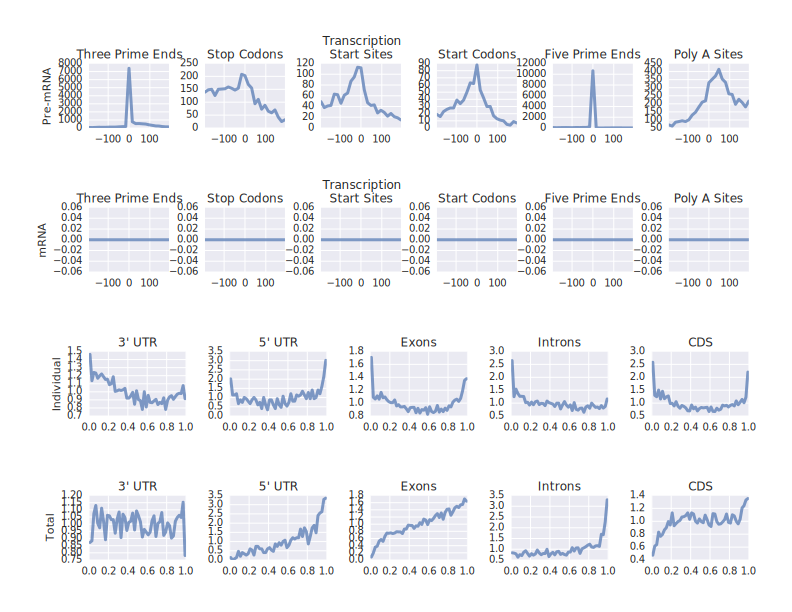

In [10]:
SVG("/nas3/gpratt/projects/msi2/analysis/msi2_v2/MSI2_ACAGTG_ACAGTG_L008_R1.polyATrim.adapterTrim.rmDup.sorted.peaks.bed.DistFig.svg")

GCCAAT Analysis
------

In [42]:
#SVG("/nas3/gpratt/projects/msi2/analysis/msi2_v2/MSI2_CAGATC_CAGATC_L008_R1.polyATrim.adapterTrim.rmDup.sorted.peaks.bed.qc_fig.svg")

In [43]:
#SVG("/nas3/gpratt/projects/msi2/analysis/msi2_v2/MSI2_CAGATC_CAGATC_L008_R1.polyATrim.adapterTrim.rmDup.sorted.peaks.bed.DistFig.svg")

#GCCAAT Analysis

In [44]:
#SVG("/nas3/gpratt/projects/msi2/analysis/msi2_v2/MSI2_GCCAAT_GCCAAT_L008_R1.polyATrim.adapterTrim.rmDup.sorted.peaks.bed.qc_fig.svg")


In [45]:
#SVG("/nas3/gpratt/projects/msi2/analysis/msi2_v1/MSI2_GCCAAT_GCCAAT_L008_R1.polyATrim.adapterTrim.rmDup.sorted.peaks.bed.DistFig.svg")

TAGCTT Analysis
------

In [46]:
#SVG("/nas3/gpratt/projects/msi2/analysis/msi2_v2/MSI2_TAGCTT_TAGCTT_L008_R1.polyATrim.adapterTrim.rmDup.sorted.peaks.bed.qc_fig.svg")


In [47]:
#SVG("/nas3/gpratt/projects/msi2/analysis/msi2_v2/MSI2_TAGCTT_TAGCTT_L008_R1.polyATrim.adapterTrim.rmDup.sorted.peaks.bed.DistFig.svg")

Analysis TGACCA
-------

In [48]:
#SVG("/nas3/gpratt/projects/msi2/analysis/msi2_v2/MSI2_TGACCA_TGACCA_L008_R1.polyATrim.adapterTrim.rmDup.sorted.peaks.bed.qc_fig.svg")



In [49]:
#SVG("/nas3/gpratt/projects/msi2/analysis/msi2_v2/MSI2_TGACCA_TGACCA_L008_R1.polyATrim.adapterTrim.rmDup.sorted.peaks.bed.DistFig.svg")

#TTAGGC Analysis

In [190]:
!cp /nas3/gpratt/projects/msi2/analysis/msi2_v2/MSI2_TTAGGC_TTAGGC_L008_R1.polyATrim.adapterTrim.rmDup.sorted.peaks.bed.qc_fig.svg $img_dir

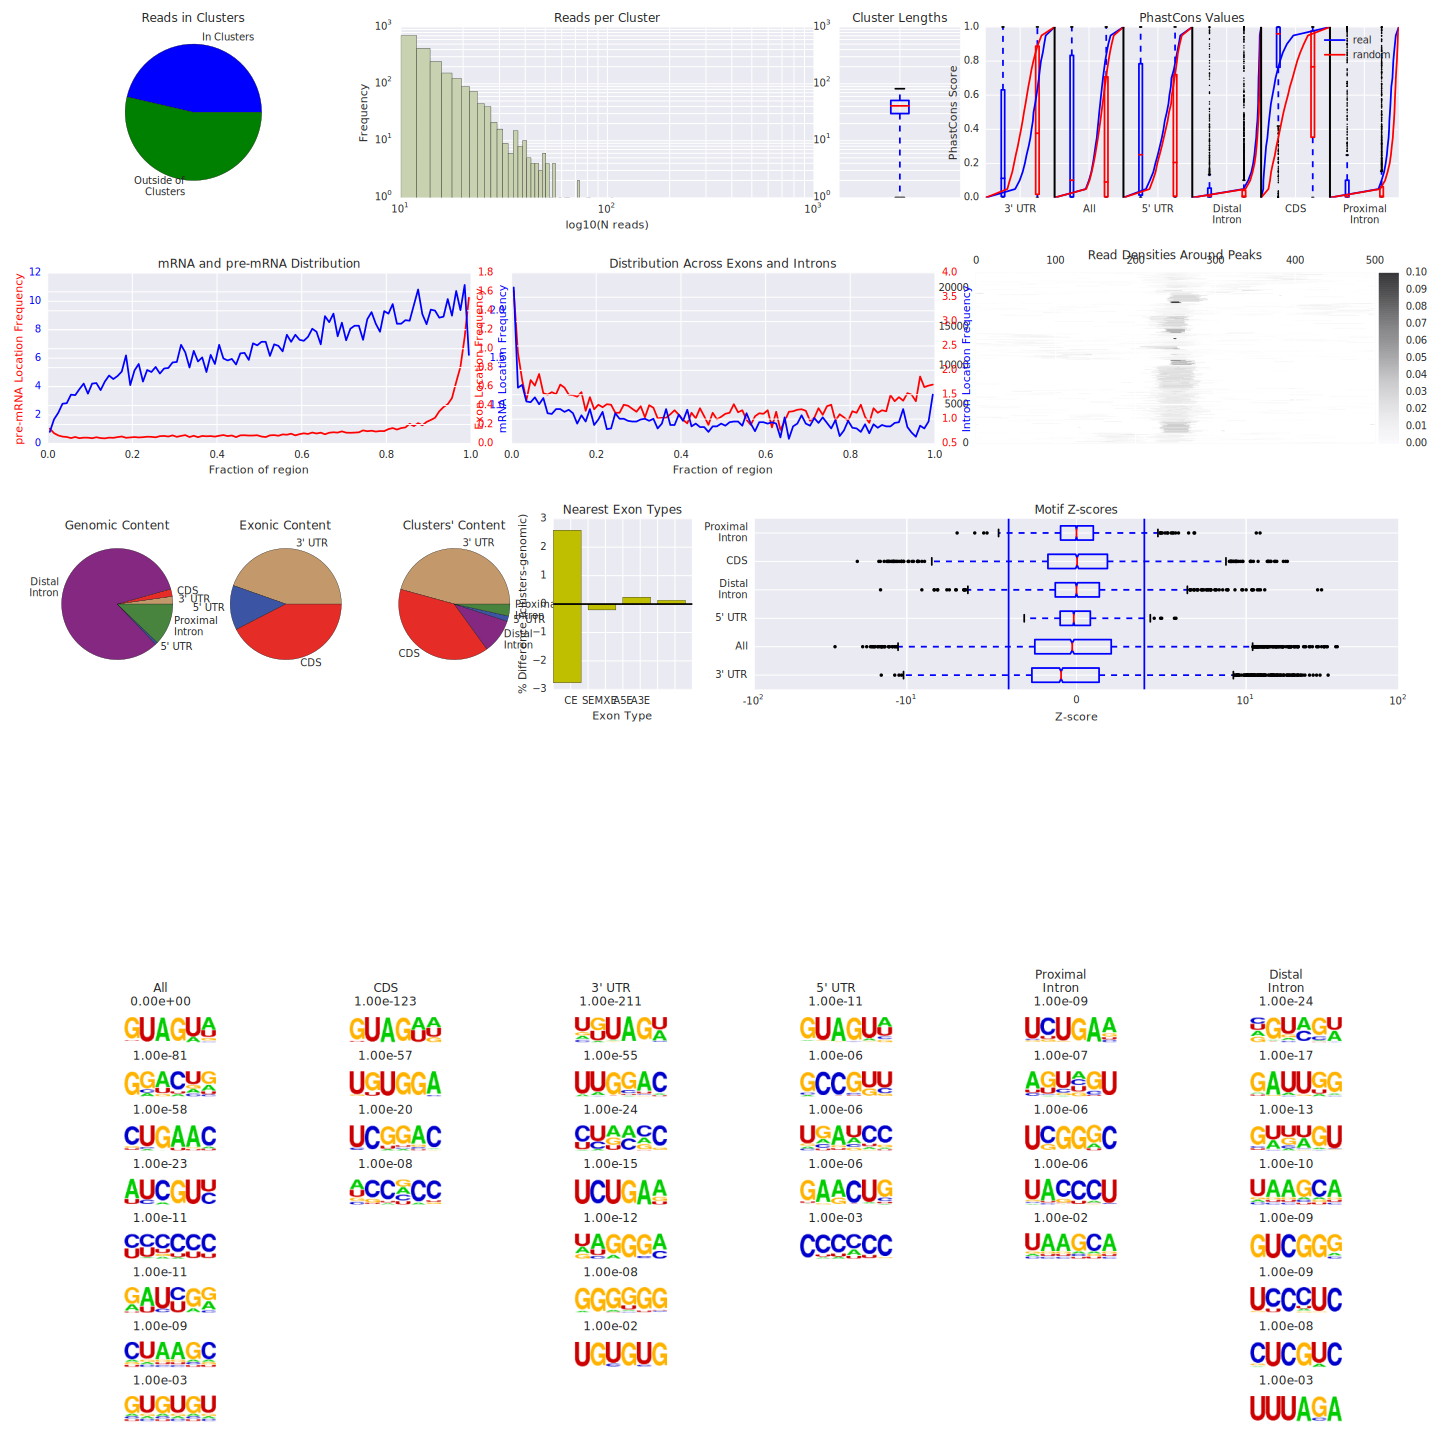

In [19]:
SVG("/nas3/gpratt/projects/msi2/analysis/msi2_v2/MSI2_TTAGGC_TTAGGC_L008_R1.polyATrim.adapterTrim.rmDup.sorted.peaks.bed.qc_fig.svg")

In [191]:
!cp /nas3/gpratt/projects/msi2/analysis/msi2_v2/MSI2_TTAGGC_TTAGGC_L008_R1.polyATrim.adapterTrim.rmDup.sorted.peaks.bed.DistFig.svg $img_dir

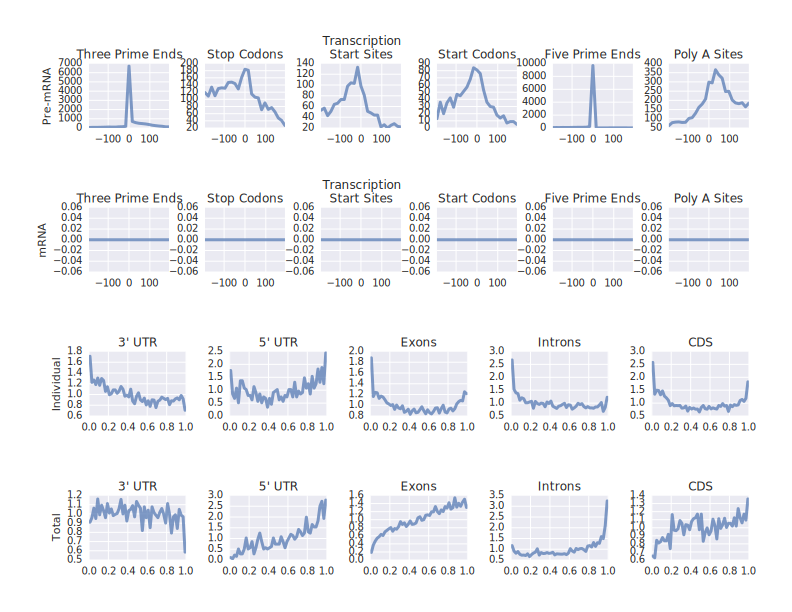

In [20]:
SVG("/nas3/gpratt/projects/msi2/analysis/msi2_v2/MSI2_TTAGGC_TTAGGC_L008_R1.polyATrim.adapterTrim.rmDup.sorted.peaks.bed.DistFig.svg")

#Looking for Repetitive Element Enrichment

In [22]:
rep_counts = pd.concat({os.path.basename(name).split(".")[0]: pd.read_table(name, sep=" ",
              names=["element", "count"], index_col=0) for name in glob.glob("/nas3/gpratt/projects/msi2/analysis/msi2_v1/*.rmRep.metrics")})

In [23]:
rep_counts = rep_counts.unstack().dropna(axis=1).T

In [24]:
rep_fraction = rep_counts.div(rep_counts.sum(), axis=1)

In [25]:
HTML(rep_fraction.sort(columns="MSI2_ACAGTG_ACAGTG_L008_R1", ascending=False).to_html())

Ranked Peaks

#Reproducablity between two good samples

In [192]:
id_to_name_mapping = {"MSI2_ACAGTG_ACAGTG_L008_R1": "100m Cells",
 "MSI2_TTAGGC_TTAGGC_L008_R1": "50m Cells"}

In [193]:
#Overlap of peaks
cells_100m = pybedtools.BedTool("/nas3/gpratt/projects/msi2/analysis/msi2_v2/MSI2_ACAGTG_ACAGTG_L008_R1.polyATrim.adapterTrim.rmDup.sorted.peaks.bed")
cells_50m = pybedtools.BedTool("/nas3/gpratt/projects/msi2/analysis/msi2_v2/MSI2_TTAGGC_TTAGGC_L008_R1.polyATrim.adapterTrim.rmDup.sorted.peaks.bed")

In [194]:
in_both = len(cells_100m.intersect(cells_50m, s=True, u=True))
only_50m = len(cells_50m) - in_both
only_100m = len(cells_100m) - in_both


In [195]:
genes_50m = {item.name.split("_")[0] for item in cells_50m}
genes_100m = {item.name.split("_")[0] for item in cells_100m}

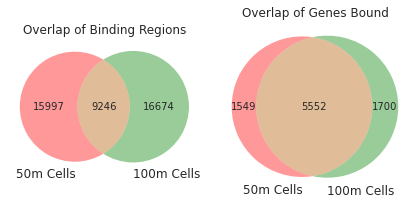

In [196]:
num_cols = 2
num_rows = 1
with dataviz.Figure(os.path.join(img_dir, "overlapping_peaks.svg"), figsize=(3.0 * num_cols, 3.0 * num_rows)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,1)
    venn2({'10': only_50m, '11': in_both, '01': only_100m}, 
          set_labels=["50m Cells", "100m Cells"], 
          ax=ax)
    ax.set_title("Overlap of Binding Regions")
    
    ax = fig.add_subplot(num_rows,num_cols,2)
    venn2([genes_50m, genes_100m], 
          set_labels=["50m Cells", "100m Cells"], 
          ax=ax)
    ax.set_title("Overlap of Genes Bound")
#Don't have expressed Genes so can't really do a hypergeometric test to see if overlap is siginifcat. 

In [197]:
!scp tscc-login.sdsc.edu:~/projects/msi2/analysis/msi2_v2/all_counts.txt .

all_counts.txt                                100%   10MB   9.9MB/s   00:01    


In [198]:
msi_counts = pd.read_table("all_counts.txt", skiprows=1, index_col=0)
msi_counts.columns = [os.path.basename(item).split(".")[0] for item in msi_counts.columns]
msi_rpkm = counts_to_rpkm(msi_counts)

In [199]:
targets_of_interest = msi_rpkm[['MSI2_ACAGTG_ACAGTG_L008_R1', 'MSI2_TTAGGC_TTAGGC_L008_R1']]
targets_of_interest[targets_of_interest == 0] = np.nan
targets_of_interest = targets_of_interest.dropna()

/nas/nas0/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


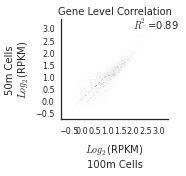

In [200]:
num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "replicate_plotting.svg"), figsize=(2.5 * num_cols, 2.5 * num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    series1 = targets_of_interest['MSI2_ACAGTG_ACAGTG_L008_R1']
    series2 = targets_of_interest['MSI2_TTAGGC_TTAGGC_L008_R1']

    dataviz.loglog_hist2d(series1, series2, ax=ax)
    sns.despine(ax=ax)
            
    ax.set_xlabel("$Log_2$(RPKM)\n{}".format(id_to_name_mapping['MSI2_ACAGTG_ACAGTG_L008_R1']), fontsize=10)
    ax.set_ylabel("{}\n$Log_2$(RPKM)".format(id_to_name_mapping['MSI2_TTAGGC_TTAGGC_L008_R1']), fontsize=10)            
    r2 = scipy.stats.linregress(series1, series2)[2]
    ax.text(2, 3, "$R^2$={:.2f}".format(r2), fontsize=10)
    ax.set_title("Gene Level Correlation", fontsize=10)
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]


#Conclusions
1. Both By overlap and Gene level RPKMs 100m and 50m cells are highly correlated

#Number of Sites Identified

In [201]:
print only_50m, only_100m

15997 16674


#Get Types of Genes Bound

In [110]:
type_counts = pd.concat({"counts_100m": pd.Series(Counter([gene_id_to_type_hg19[gene] for gene in genes_100m])),
                         "counts_50m": pd.Series(Counter([gene_id_to_type_hg19[gene] for gene in genes_50m])),
                         "total": pd.Series(Counter(gene_id_to_type_hg19.values()))})

type_counts = type_counts.unstack().fillna(0)

fraction_counts[fraction_counts == 0] = np.nan
fraction_counts = fraction_counts.dropna(axis=1)
fraction_counts = type_counts.ix[['counts_100m', 'counts_50m']] / type_counts.ix['total']

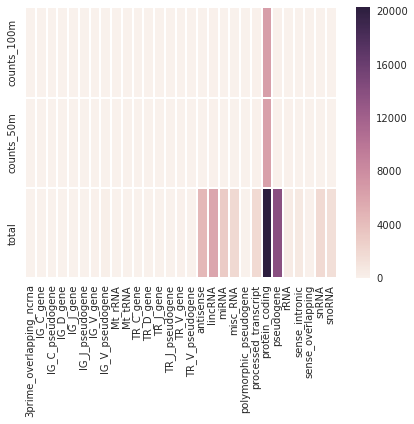

In [209]:
with dataviz.Figure(os.path.join(img_dir, "count_type_bound.svg"), figsize=(6,6)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.heatmap(type_counts.unstack().fillna(0), ax=ax)

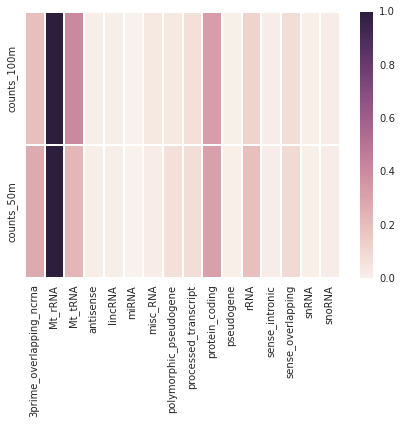

In [210]:
with dataviz.Figure(os.path.join(img_dir, "fraction_type_bound.svg"), figsize=(6,6)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.heatmap(fraction_counts, ax=ax)

#Conclusions
Fraction Counts isn't super interesting, it appers to bind primary protein coding genes, other targets are only enriched because so few genes are bound.  

#Ranked Target Lists
Bed files of ranked peaks (by p-value) can be found on our server here:
http://sauron.ucsd.edu/msi2/

To understand a bed file look at this documentation (ask me if something doesn't make sense):
http://genome.ucsc.edu/FAQ/FAQformat.html#format1

Breifly the first 3 columns are the hg19 (or mm9) genomic locations, the 4th column is the gene name (this won't work for the mm9 genes), the 5th coulmn is the p-value, and the 6th is the strand.  Ignore the other columns.  

#Code to generate ranked list

In [37]:
for name, bedtool in bedtools.items():
    try:
        bedtool = bedtool.each(gene_id_mapper_hg19).saveas()
    except:
        bedtool = bedtool.each(gene_id_mapper_mm9).saveas()
    bedtool = pybedtools.BedTool(sorted(bedtool, key=lambda x: float(x.score))).saveas(name + ".bed")

In [38]:
bedtool.head()

chr5	147072624	147072704	Cdk8	1.86570622181e-25	+	147072664	147072668
 chr9	123371066	123371151	Lars2	1.0068542389e-21	+	123371105	123371109
 chr16	57391699	57391786	2610528E23Rik	2.32938188674e-18	-	57391741	57391745
 chr10	88350956	88351002	Slc5a8	4.00089891772e-18	+	88350984	88350988
 chr18	61144473	61144534	Camk2a	8.04177253605e-17	+	61144503	61144507
 chr13	59037961	59038015	Ntrk2	2.05755767507e-16	+	59038001	59038005
 chr18	23818069	23818124	Dtna	8.11423889507e-16	+	23818103	23818107
 chr18	82754319	82754384	Mbp	3.778164232e-15	+	82754353	82754357
 chr2	102625012	102625103	Slc1a2	4.51560598797e-15	+	102625029	102625033
 chrX	162824152	162824245	Gpm6b	1.06609366697e-13	+	162824175	162824179



#GO Analysis

In [ ]:
hg19_go = hg19GO()
mm9_go = mm9GO()

bedtools = {os.path.basename(name).split(".")[0] : pybedtools.BedTool(name) for name in glob.glob("/nas3/gpratt/projects/msi2/analysis/msi2_v2/*.peaks.bed")}
gene_names = {name: [interval.name.split(".")[0] for interval in bedtool] for name, bedtool in bedtools.items()}

In [180]:
go_analysis = {
    id_to_name_mapping["MSI2_ACAGTG_ACAGTG_L008_R1"] : hg19_go.enrichment(set(gene_names['MSI2_ACAGTG_ACAGTG_L008_R1'])),
    #"MSI2_CAGATC_CAGATC_L008_R1" : mm9_go.enrichment(gene_names['MSI2_CAGATC_CAGATC_L008_R1']),
    #"MSI2_GCCAAT_GCCAAT_L008_R1" : mm9_go.enrichment(gene_names['MSI2_GCCAAT_GCCAAT_L008_R1']),
    #"MSI2_TAGCTT_TAGCTT_L008_R1" : hg19_go.enrichment(gene_names['MSI2_TAGCTT_TAGCTT_L008_R1']),
    #"MSI2_TGACCA_TGACCA_L008_R1" : hg19_go.enrichment(gene_names['MSI2_TGACCA_TGACCA_L008_R1']),
    id_to_name_mapping["MSI2_TTAGGC_TTAGGC_L008_R1"] : hg19_go.enrichment(set(gene_names['MSI2_TTAGGC_TTAGGC_L008_R1']))
    }

go_analysis = pd.concat(go_analysis)

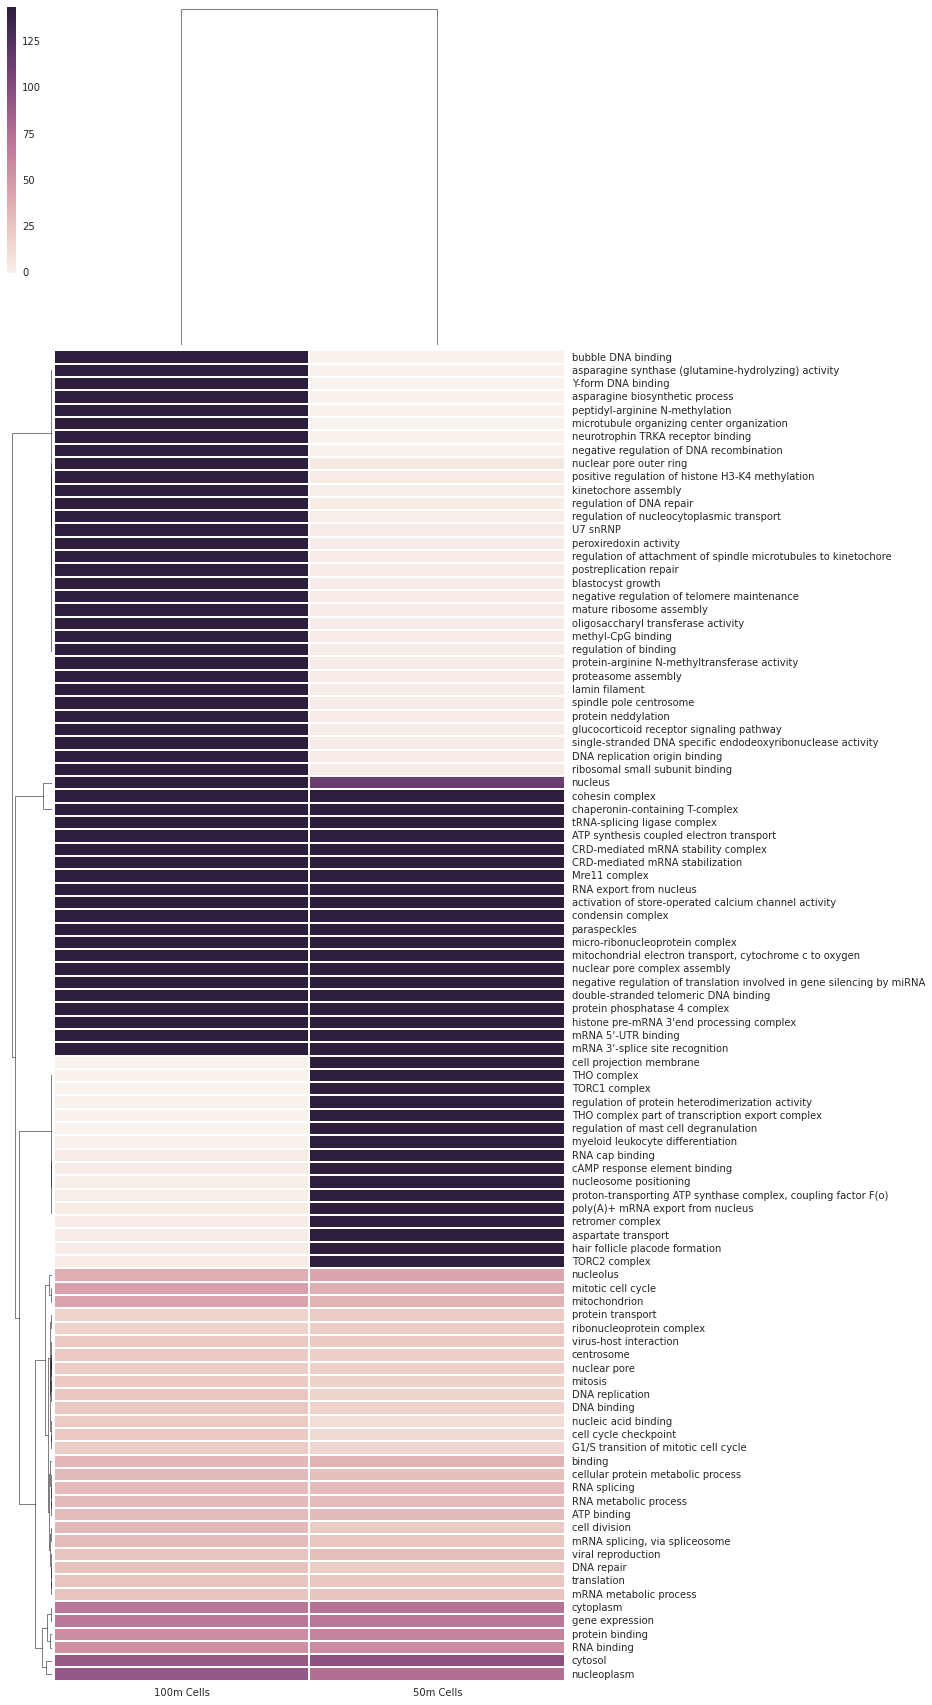

In [208]:
plot_go_enrichment(go_analysis, filter_value=10, max_terms=100, figsize=(10,30))
fig = plt.gcf()
fig.savefig(os.path.join(img_dir, "go_enrichment.svg"))

#Lets Make some nicer figures than clip analysis

In [215]:
import cPickle as pickle
from clipper.src import CLIP_analysis_display

In [224]:
clip_analysis_100m = CLIP_analysis_display.ClipVisualization(open("/nas3/gpratt/projects/msi2/analysis/msi2_v2/MSI2_ACAGTG_ACAGTG_L008_R1.polyATrim.adapterTrim.rmDup.sorted.peaks.bed.clip_analysis.pickle"))
clip_analysis_50m  = CLIP_analysis_display.ClipVisualization(open("/nas3/gpratt/projects/msi2/analysis/msi2_v2/MSI2_TTAGGC_TTAGGC_L008_R1.polyATrim.adapterTrim.rmDup.sorted.peaks.bed.clip_analysis.pickle"))

In [ ]:
analysis_dir = "/nas3/gpratt/projects/

In [225]:
cp /nas3/gpratt/projects/msi2/analysis/msi2_v2/*.bam .

/nas3/gpratt/iPython_Notebook


In [226]:
clip_analysis_100m.features_transcript_closest['stop_codons']

<BedTool(MISSING FILE: MSI2_ACAGTG_ACAGTG_L008_R1.polyATrim.adapterTrim.rmDup.sorted.peaks.bed_stop_codons_transcript.bed)>